In [1]:
from functools import partial
from fvhoe.boundary_conditions import BoundaryCondition
from fvhoe.initial_conditions import shu_osher_1d
from fvhoe.solver import EulerSolver
from fvhoe.visualization import plot_1d_slice
import matplotlib.pyplot as plt
import numpy as np
import os
from pickle import dump, load
import sys
import warnings

warnings.filterwarnings("ignore")

sys.path.append("../../sd/src")
sys.path.append("../../sd/utils")

from initial_conditions_2d import Shu_Osher
from sd_simulator import SD_Simulator
import sd_visualize as sdv

In [2]:
N = 100
p = 3
T = 1.8
gamma = 1.4
boxlen = 10

n_dofs = N * (p + 1)

In [3]:
fv = EulerSolver(
    w0=shu_osher_1d,
    x=(0, boxlen),
    nx=n_dofs,
    px=p,
    riemann_solver="hllc",
    bc=BoundaryCondition(
        x="dirichlet",
        x_value=(
            {
                "rho": 3.857143,
                "mx": 3.857143 * 2.629369,
                "my": 0,
                "mz": 0,
                "E": 10.33333 / (gamma - 1) + 0.5 * 3.857143 * 2.629369 * 2.629369,
            },
            {
                "rho": 1 + 0.2 * np.sin(5 * 5),
                "mx": 0,
                "my": 0,
                "mz": 0,
                "E": 1 / (gamma - 1),
            },
        ),
    ),
    gamma=gamma,
    a_posteriori_slope_limiting=True,
    density_floor=False,
    pressure_floor=False,
    slope_limiter="minmod",
)

fv.run(T)

100%|██████████| 1.8/1.8 [00:08]                 


In [4]:
# solve with spectral differences

sd_data_path = "/scratch/gpfs/jp7427/fvhoe/snapshots/shu_osher_sd/"
overwrite = False

try:
    if overwrite:
        raise FileNotFoundError
    with open(sd_data_path + "arrs.pkl", "rb") as f:
        sd = load(f)
    print("Snapshot found!")
except FileNotFoundError:
    sd = SD_Simulator(
        n=p,
        Nx=N,
        Ny=1,
        init_fct=Shu_Osher,
        BC=["ic", "periodic"],
        gamma=gamma,
        detect_troubles=True,
        boxlen_x=boxlen,
        use_cupy=False,
    )
    sd.perform_time_evolution(T)

    # create fake snapshot
    W = sd.transpose_to_fv(sd.dm.W_cv)
    x = sd.dm.x_cv[2:-2]

    log = dict(
        x=x,
        y=np.array([0.5]),
        z=np.array([0.5]),
        t=sd.time,
        w=W[:, 0, ...].reshape(5, n_dofs, 1, 1), ["rho", "vx", "vy", "P", "h"],
    )
    sd = [log]

    # save
    if not os.path.exists(sd_data_path):
        os.makedirs(sd_data_path)
    with open(sd_data_path + "arrs.pkl", "wb") as f:
        dump(sd, f)

1212 time steps (t = 1.8, Execution time: 32.226829 s)8001850327805335, min p = 0.9999722576645218)


t=1.8, x=[0.0125, 9.9875], y=0.5, z=0.5
t=1.8, x=[0.005635083268962915, 9.994364916731037], y=0.5, z=0.5
t=1.8, x=[0.0125, 9.9875], y=0.5, z=0.5
t=1.8, x=[0.005635083268962915, 9.994364916731037], y=0.5, z=0.5
t=1.8, x=[0.0125, 9.9875], y=0.5, z=0.5
t=1.8, x=[0.005635083268962915, 9.994364916731037], y=0.5, z=0.5


(5.0, 7.5)

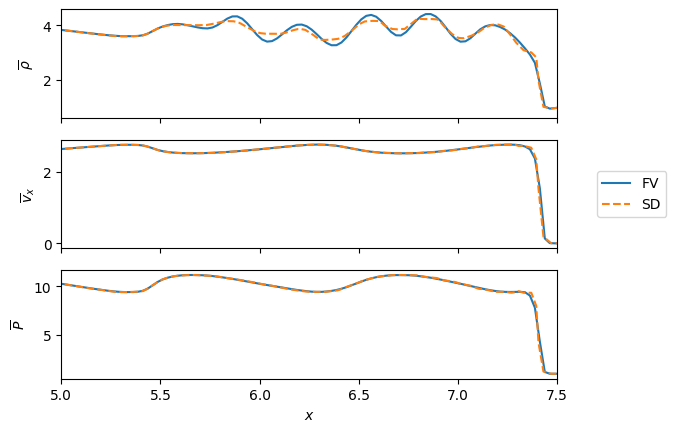

In [5]:
fig, ax = plt.subplots(3, sharex=True)

for i, (var, label) in enumerate(
    zip(
        ["rho", "vx", "P"],
        [r"$\overline{\rho}$", r"$\overline{v}_x$", r"$\overline{P}$"],
    )
):
    plot_1d_slice(fv, ax[i], y=0.5, z=0.5, param=var, label="FV")
    plot_1d_slice(sd, ax[i], y=0.5, z=0.5, param=var, linestyle="--", label="SD")
    ax[i].set_ylabel(label)

ax[1].legend(loc="center", bbox_to_anchor=(1.15, 0.5))
ax[2].set_xlabel("$x$")
ax[2].set_xlim(5, 7.5)